In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


# sns.set(style='white', context='notebook', palette='deep')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [73]:
# Load the data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
# Normalize the data
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

X_train = X_train / 255.0
test = test / 255.0

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

random_seed = 67
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [74]:
train.shape

(42000, 785)

In [75]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

from keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0,
                             patience=1, verbose=1, mode='auto')

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 50
batch_size = 128



In [76]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [79]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size, validation_steps=1
                              , callbacks=[learning_rate_reduction, earlystopper])

# history = model.fit(X_train,Y_train,
#                     epochs = epochs, validation_data = (X_val,Y_val),
#                     verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size, validation_steps=1
#                     , callbacks=[learning_rate_reduction])

Epoch 1/50
 - 9s - loss: 0.0692 - accuracy: 0.9807 - val_loss: 0.0343 - val_accuracy: 0.9905
Epoch 2/50
 - 9s - loss: 0.0634 - accuracy: 0.9829 - val_loss: 0.0290 - val_accuracy: 0.9921
Epoch 3/50
 - 9s - loss: 0.0560 - accuracy: 0.9848 - val_loss: 0.0625 - val_accuracy: 0.9867
Epoch 4/50
 - 9s - loss: 0.0588 - accuracy: 0.9844 - val_loss: 0.0251 - val_accuracy: 0.9914
Epoch 5/50
 - 9s - loss: 0.0496 - accuracy: 0.9865 - val_loss: 0.0332 - val_accuracy: 0.9914

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
 - 9s - loss: 0.0368 - accuracy: 0.9898 - val_loss: 0.0263 - val_accuracy: 0.9943
Epoch 7/50
 - 9s - loss: 0.0333 - accuracy: 0.9904 - val_loss: 0.0249 - val_accuracy: 0.9950
Epoch 8/50
 - 9s - loss: 0.0358 - accuracy: 0.9901 - val_loss: 0.0241 - val_accuracy: 0.9948
Epoch 9/50
 - 9s - loss: 0.0356 - accuracy: 0.9907 - val_loss: 0.0346 - val_accuracy: 0.9929
Epoch 10/50
 - 9s - loss: 0.0351 - accuracy: 0.9908 - val_loss: 0.0302 - val_accur

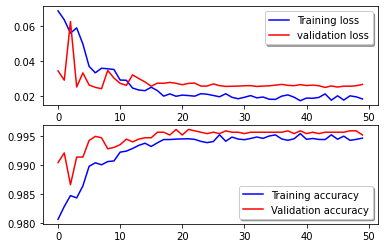

In [80]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [81]:
y_test = np.argmax(model.predict(test), axis=1)

In [87]:
result = pd.DataFrame(columns = ['ImageId', 'Label'])
result['ImageId'] = range(len(y_test))
result['Label'] = y_test
result.to_csv('submssion', index=False)

In [86]:
result

,ImageId,Label
0,0,2
1,1,0
2,2,9
3,3,0
4,4,3
...,...,...
27995,27995,9
27996,27996,7
27997,27997,3
27998,27998,9
